In [46]:
import re
import string
import requests
from bs4 import BeautifulSoup
import pickle
import os
import pandas as pd
import collections
from collections import Counter
pd.set_option('max_colwidth',150)

### Data Cleaning

As part of the cleaning process i choose to do the standard cleaning which is associated with 
1. Removing punctuations 
2. Removing unrecognised symbols and characters 
3. Unknown combination of words, as observed from the few lines of transcript in the data frame 
4. Lemmatization  
5. Parts of Speech removal 

Also non standard and use case specific cleaning such as 
6. Common words removal (Used by most of the comedians)
7. Stop words and non-english words removal (With the exception of swear words, as we need them for analysis)
8. Removing all the words that are inside the square brackets, as they express more about the audience reaction and less about the script and content. 


In [2]:
data = pd.read_pickle("rawfulldata.pkl")
kevindata = pd.read_pickle("rawkevindata.pkl")
amydata = pd.read_pickle("rawamydata.pkl")
johndata = pd.read_pickle("rawjohndata.pkl")
hasandata = pd.read_pickle("rawhasandata.pkl")
kevindata = pd.read_pickle("rawkevindata.pkl")

In [3]:
# Apply a first round of text cleaning techniques

def cleantext(test):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    test = test.lower()
    test = re.sub('[♪…–\xa0♫’‘“”:-]', '', test) # removing various symbols mentioned inside the square brackets
    test = test.replace('\n',' ') #replacing new line symbol with space
    test = re.sub('[♬—]', '', test) # removing various symbols mentioned inside the square brackets
    test = re.sub("[\(\[].*?[\)\]]", "", test) #to remove all those inside brackets, such as cheering, clapping etc. 
    test = re.sub('[%s]' % re.escape(string.punctuation), '', test) #to clean of punctuation marks
    test = re.sub('o{3,6}','',test) #to remove ooo, oooo, ooooo and oooooo
    test = re.sub('a{2,6}','',test) #to remove aa to aaaaaa
    test = re.sub('m{2,6}','',test) #to remove mm to aaaaaa
    test = re.sub('a{3,}h','',test) #to remove aaah or any variation of aaa...h
    test = re.sub('\w*\d\w*', '', test) #to remove non word texts
    return test

basic = lambda x: cleantext(x)

In [4]:
# fd stands for full data and kd stands for kevin data and so on. 
# applying the cleaning process for all the dataframes.
test = pd.DataFrame(data.transcript.apply(basic))
testo = test.copy() # duplicate for comparison
kd_clean = pd.DataFrame(kevindata.transcript.apply(basic))
ad_clean = pd.DataFrame(amydata.transcript.apply(basic))
jd_clean = pd.DataFrame(johndata.transcript.apply(basic))
hd_clean = pd.DataFrame(hasandata.transcript.apply(basic))

###### Words such as 'screaming','clapping','whooping','cheering','audience','yells','whoos','cheers','claps','screams','laughing','laughs','laughter','whooing','chuckling','cackling','whistling','uproarious','uproar','howling','roaring','continued','giggles','indistinct','vocals','yelling', anything that have to do with reactions have all been removed
###### And I shall try lemmatizing here as stemming does not do any justification for the process and also we see many different forms of verbs get, say, go etc. on a glance at the scripts. 

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
for i in test.index:
    tokens = word_tokenize(test.loc[i][0])
    tojoin = []
    for wor in tokens:
        tojoin.append(wordnet_lemmatizer.lemmatize(wor,pos = "v"))
    test.loc[i][0] = ' '.join(tojoin)
    
test.head()

,transcript
Tiffany Haddish,people think they know everything about me well heres something they probably dont know hava nagila hava nagila hava nagila venis mecha hava nagil...
Ricky Gervais,hello hello how you do great thank you wow calm down shut the fuck up thank you what a lovely welcome im gon na try my hardest tonight youre think...
John Mulaney,welcome to radio city music hall its time any question no walk with me good even hi im john mulaney nice to meet you jon brion ladies and gentleme...
Hasan Minhaj,whats up davis whats up im home i have to bring it back here netflix say where do you want to do the special la chicago new york i be like nah son...
Ali Wong,ladies and gentlemen please welcome to the stage ali wong what yall think yall wasnt gon see me im the osirus of this shit wutang be here forever ...


##### Good enough!! the words doing has been made into do and said to say, was to be...but however gonna became gon na and evening turned into 'even', we shall remove these when removing the stop words, but also shall add in some of the stop words of our own. A quick check on all the scripts can help you come up with some more words for you to remove something like 'hava' and 'nagila' and 'mecha' from Tiffany's script

###### Choosing to remove all non english words from analysis, to save the problem of adding words to stop words

In [8]:
test.replace(['fuckin', 'niggas', 'niggarettes'], ['fuck','nigga','nigga'],inplace = True) 
#as i found the usage of these terms when viewing the dataframe.

In [9]:
import nltk
words = set(nltk.corpus.words.words())

swearwords = ['fuck','shit','cunt','bitch','nigga','ho','goddamn','pussy']

for j in swearwords:
    words.add(j)         
#Adding some custom swear words to the set as i am not certain they would be present in the english words and this would 
#lead to the possibility of eliminating these swear words from the data

for i in test.index:
    tokens = word_tokenize(test.loc[i][0])
    words1 = [w for w in tokens if w.lower() in words or not w.isalpha()]
    test.loc[i][0] = ' '.join(words1)
    
test

,transcript
Tiffany Haddish,people think they know everything about me well something they probably dont know tonight tonight let party let party let party tonight they call ...
Ricky Gervais,hello hello how you do great thank you wow calm down shut the fuck up thank you what a lovely welcome gon na try my tonight think relax weve have ...
John Mulaney,welcome to radio city music hall its time any question no walk with me good even hi nice to meet you ladies and thank you for come to see me at ra...
Hasan Minhaj,whats up whats up home i have to bring it back here say where do you want to do the special la new york i be like son this have um this have be a ...
Ali Wong,ladies and please welcome to the stage wong what think wasnt gon see me the of this shit be here forever its like this my and my let do it like th...
Pete Davidson,so try to get me fire from my first year and this be that story so its like or and its the finale of and be so shock and happy that i didnt get fi...
Kevin Hart,its honey babe go come alright see you later love you baby let go show time ill see you on the other side baby let go let do what you do have a go...
Amy Schumer,yes thank you so much thank you i use to do lot of do i would blame my disgust behavior on the city i be in you know how people would be like you ...
Ken Jeong,the ken crazy rich give it up for ken i say the joker be a want man he make his way all across the land see him sift through the sand so ill tell ...
Ellen Degeneres,a original comedy special thank you so much thank you that be lovely energy i appreciate it thank you so much for be so its be since and when i de...


In [10]:
# A quick check to see if our words have the swear words we have added 
for i in swearwords:
    if i in words:
        print(i,True)

fuck True
shit True
cunt True
bitch True
nigga True
ho True
goddamn True
pussy True


Adding the stop words without apostrophes as they are so in our dataset and also adding some other words. 
Don't have to add the terms like hava, nagila etc as they have been eliminated through the non-english word removal. 

In [11]:
stop_words = set(stopwords.words('english'))
relist = ['t','y','i','ll','d','o','s','a','m'] # remove list == relist 
adlist = ['hadnt','wasnt','dont','its','lets','youd','shes','werent','youll','doesnt','isnt','wont','youre','neednt',
          'didnt','youve','hasnt','wouldnt','shouldnt','couldnt','mightnt','aint','arent','hes','yours','his','im','thats',
         'theyre','id','theres','ta','gon','na','ill','snl'] #add list == adlist

for i in relist:
    stop_words.remove(i)  #removing some existing stop words from the set
    
for j in adlist:
    stop_words.add(j) #adding some custom stop words to the set

print(stop_words)

{'him', 'any', "you'd", 'of', 'theres', 'the', 'its', "shouldn't", 'while', 'just', 'youre', 'over', 'her', 'for', 'doesn', 'these', 'haven', 'wasn', 'further', 'herself', 'to', 'mustn', 'before', 'up', "should've", 'wasnt', 'own', 'you', 'isnt', 'she', 'has', 'or', 'most', 'his', 'will', 'ain', 'nor', 'dont', 'ourselves', 'who', 'under', 'this', 'here', "wouldn't", 'by', 'once', 'have', 'weren', 'yourselves', 'youll', 'your', 'am', 'but', 'and', 'doing', 'won', 'can', 'out', "doesn't", 'me', 'itself', "don't", "didn't", "haven't", "that'll", 'mightnt', 'more', "weren't", 'no', 'during', 'yourself', 'with', 'did', 'between', 'both', 'didn', 'our', 'we', 'then', 'above', 'into', "wasn't", 'doesnt', 'very', 'them', 'shes', 'being', 'hasnt', 'it', 'are', 'again', 'aren', 'im', 'didnt', 'theyre', 'not', 'through', 'until', 'what', "you'll", 'couldnt', "she's", 'be', "isn't", 'youve', "hadn't", 'themselves', "you're", 're', 'how', 'couldn', "couldn't", 'isn', 'wouldnt', 'why', 'that', "you'

In [12]:
# Cleaning the test dataset somemore by removing stop words. 
for i in test.index:
    tokens = word_tokenize(test.loc[i][0])
    words = [w for w in tokens if not w in stop_words]
    test.loc[i][0] = ' '.join(words)
    
test.head()

,transcript
Tiffany Haddish,people think know everything well something probably know tonight tonight let party let party let party tonight call tiffany say make laugh real h...
Ricky Gervais,hello hello great thank wow calm shut fuck thank a lovely welcome try tonight think relax weve worth see a legend shut a god ordinary guy know go ...
John Mulaney,welcome radio city music hall time question walk good even hi nice meet ladies thank come see radio city music hall i love play guy build venue co...
Hasan Minhaj,whats whats home i bring back say want special la new york i like son um a good year i recently get marry guy thank thank thank i need clap a heav...
Ali Wong,ladies please welcome stage wong think see shit forever like let like rub ass moonshine let take back i bomb atomically hypotheses cant define i l...


##### The dataset looks fairly ok for analysis but lets also see most used words for each of the comedian in descending order and decide on further cleaning. 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
fd_cv = cv.fit_transform(test.transcript)
fd_dtm = pd.DataFrame(fd_cv.toarray(), columns=cv.get_feature_names())
fd_dtm.index = test.index
fd_dtm

,abandon,abduct,ability,abject,able,abortion,absolute,absolutely,absorb,abstract,...,young,younger,youse,youth,yuck,zee,zero,zodiac,zone,zoo
Tiffany Haddish,0,0,0,0,1,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
Ricky Gervais,0,0,1,1,2,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,1
John Mulaney,0,0,0,0,1,0,0,1,0,0,...,2,1,0,1,0,0,0,0,0,2
Hasan Minhaj,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,2,1,0,0,0
Ali Wong,0,0,0,0,0,0,0,0,1,0,...,3,1,0,0,0,0,2,0,1,0
Pete Davidson,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kevin Hart,1,0,0,0,2,0,0,1,0,0,...,0,2,0,0,0,0,0,0,0,0
Amy Schumer,0,0,0,0,2,1,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0
Ken Jeong,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Ellen Degeneres,0,0,0,0,1,0,0,0,0,0,...,1,1,6,0,0,0,0,0,0,0


lets arrange them for every comedian in decreasing order

In [14]:
topwords = []
for i in fd_dtm.index:
    topwords.extend(fd_dtm.loc[i].sort_values(ascending=False).head(30).index)

occurrences = collections.Counter(topwords)
print(occurrences)

Counter({'like': 16, 'know': 16, 'say': 16, 'right': 16, 'look': 16, 'come': 16, 'make': 15, 'time': 15, 'oh': 14, 'fuck': 13, 'people': 13, 'want': 13, 'yeah': 12, 'think': 12, 'guy': 11, 'shit': 10, 'let': 8, 'thing': 8, 'tell': 8, 'man': 8, 'good': 7, 'really': 7, 'day': 7, 'little': 6, 'mean': 6, 'love': 6, 'hey': 6, 'happen': 5, 'god': 5, 'thank': 5, 'talk': 4, 'baby': 4, 'cause': 4, 'try': 3, 'great': 3, 'life': 3, 'need': 3, 'feel': 3, 'start': 3, 'bitch': 2, 'work': 2, 'joke': 2, 'big': 2, 'die': 2, 'old': 2, 'wife': 2, 'walk': 2, 'nice': 2, 'sit': 2, 'dad': 2, 'girl': 2, 'husband': 2, 'new': 2, 'leave': 2, 'play': 2, 'gay': 2, 'dude': 2, 'house': 2, 'son': 2, 'men': 2, 'doctor': 2, 'way': 2, 'dance': 2, 'phone': 2, 'tiffany': 1, 'bad': 1, 'party': 1, 'learn': 1, 'sleep': 1, 'crazy': 1, 'tweet': 1, 'nut': 1, 'bob': 1, 'laugh': 1, 'bite': 1, 'horse': 1, 'money': 1, 'college': 1, 'bread': 1, 'use': 1, 'hasan': 1, 'brown': 1, 'parent': 1, 'white': 1, 'whats': 1, 'school': 1, 'bike

There are words all 16 of them have used and there are also words which most of them have used. These dont contribute to the analysis, as they dont give us any differentiating factor between the stand up delivery or scripts. Hence, i chose to remove these words as well. [Uggh! So much "removing" happening]

I shall remove the ones with count greater than or equal to 8. (words 50% of the comedians have used). It is a threshold that i have chosen, originally it was 75% but the word cloud made no proper sense forcing me to lower the threshold. 

In [44]:
commonwwords = ['like','know','say','right','look','come','make','time','oh','yeah','think','people','want','guy','thank'
                ,'go','get','would','let','good','tell','one','back','take','really','thing','man','randy','show','see']

# These commonwords to be removed also have additional words which when observed word cloud had to be removed. 

In [45]:
for i in test.index:
    tokens = word_tokenize(test.loc[i][0])
    words = [w for w in tokens if not w in commonwwords]
    test.loc[i][0] = ' '.join(words)
    
test

,transcript
Tiffany Haddish,everything well something probably tonight tonight party party party tonight call tiffany laugh real hard baby i microphone none home alone leave ...
Ricky Gervais,hello hello great wow calm shut fuck a lovely welcome try tonight relax weve worth a legend shut a god ordinary round talk sort sort a way better ...
John Mulaney,welcome radio city music hall question walk even hi nice meet ladies radio city music hall i love play build venue could stage a little bite much ...
Hasan Minhaj,whats whats home i bring special la new york i son um a year i recently marry i need clap a heavy ring heavy a reverse lord ring situation i a rin...
Ali Wong,ladies please welcome stage wong shit forever rub ass moonshine i bomb atomically hypotheses cant define i lyrically perform arm robbery flee lott...
Pete Davidson,try fire first year story finale shock happy i fire a feel i relive every week i awesome i cant i still cant believe funny um i celebrate host a c...
Kevin Hart,honey babe alright later love baby side baby a chief sir baby i watch name pray amen last joke viral stroke put baby a spiral soprano c keep a hig...
Amy Schumer,yes much i use lot i blame disgust behavior city i fuck last night crowd last night fuck stranger crazy arm robbery silly concern fuck pregnant i ...
Ken Jeong,ken crazy rich give ken i joker a way across land sift sand story joker thief night h goddamn goddamn much fuck god i even i love ken i love bitch...
Ellen Degeneres,a original comedy special much lovely energy i appreciate much since i decide a friend mine house i stand i i hop a i yes well still relatable i y...


###### Now finally lets see what the word cloud says about their genre and manner of comedy

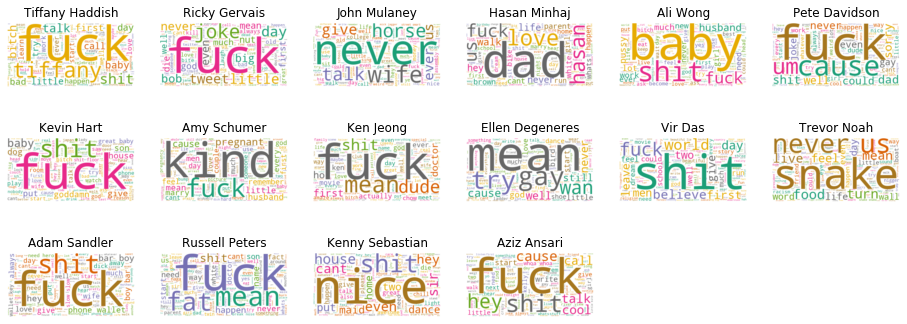

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [16, 6]

full_names =  ['Tiffany Haddish', 'Ricky Gervais', 'John Mulaney', 'Hasan Minhaj', 'Ali Wong', 'Pete Davidson',
          'Kevin Hart', 'Amy Schumer','Ken Jeong', 'Ellen Degeneres','Vir Das','Trevor Noah','Adam Sandler',
          'Russell Peters','Kenny Sebastian','Aziz Ansari']

# Create subplots for each comedian
for index, comedian in enumerate(test.index):
    wc.generate(test.transcript[comedian])
    
    plt.subplot(3, 6, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

##### Its pretty clear to eliminate the go,get,would and let from the dataset and hence shall add these to the commonwords. 
Below is the original version of the wordcloud before cleaning the additional words

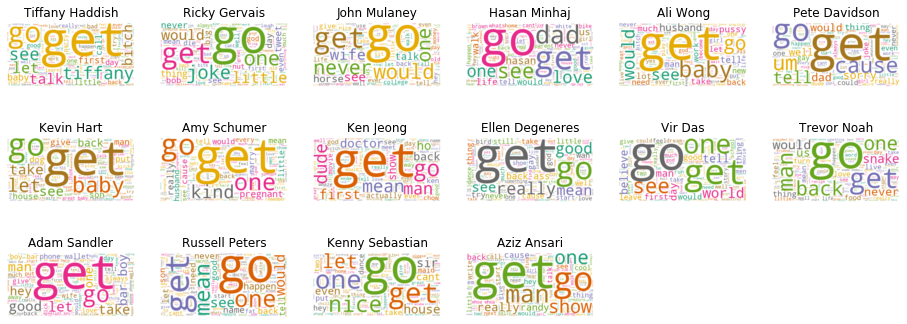

From the word cloud, It is quite evident that most of the comedians aggresively use swear fords, leaving us quite a handful such as john, hasan, ali, amy, ellen, kenny and trevor. But hasan does use it minimally while ali wong, kevin, vir, adam, russel, Tiffany and aziz have used wide variety of swearwords. 

1. while Ricky grevais's most used word happens to be joke, joking, jokes itself as the transcript was from golden globes and i believe there was a necessity to add the word not to offend anyone or also just because it is his most used word. We can't say yet as we only have one transcript of his. 
2. John mulaney's special was about wife and related stuff which is pretty evident. 
3. Ali wong's and kevin hart's also talk about similar topics as their specials are related to wong's life as a wife, and about kevin's life with his babies/kids. 
4. Amy schumer's been travelling on the same boat and the topic seemes to be her life and marital life. 
5. Kenjeong who based his entire comic special on his wife, talks about his profession (doctor) and it is not evident what the main topic however is from the wordcloud
6. Pete also doesn't give off any topic related words but rather seemed to be using a lot of slang, which might attract millenials or the younger generation
7. Ellen, as well, talks about nothing in particular, a deeper analysis of word *mean* has to be made. She also talked about gays, presumed from the most used word. 
8. Vir das, an intellectual, talks about more abstract and wide-spread topic as he includes world, see(ing), men etc. 
9. Trevor noah doesnt give much either, which leaves room for us to figure out what that snake meant in the analysis. Is he referring to someone as snake or is he narrating a story of snake, we dont know yet. 
10. Adamsandler perhaps chose the narration style and talks about incidents in live, from what we understand, mostly from when he is drunk or someone else is, going by the words bar boy, phone, wallet wife etc. 
11. Russell also used the word mean, but having watched his stand up shows, he is rather talking about people at a certain place, as usually his stand up shows talk about cities, cultures and people. 
12. Kenny's topics have to be the simplest, it could be seen that he choses everyday topics like mom, maid, house etc. 
13. Aziz ansaris doesnt give off any particular content to dwell over. 
14. Hasan however talked about love, parents and his dad which is a diversion from his usual subjects from his netflix shows, which are quite technical and needs a lot of understanding about the worlds' problems and certain situations. 